In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc

In [2]:
df = pd.read_csv("/content/creditCards.csv")

In [11]:
df = df.rename(columns={"Class": "Label"})
df.dropna(subset=['Label'], inplace=True)

In [15]:
X = df.drop(columns=["Label", "Time"])  # Drop both the target and 'Time' column
y = df["Label"]


In [5]:
df["Hour"] = (df["Time"] / 3600) % 24

In [6]:
print("First 5 rows of the dataset:")
print(df.head())

First 5 rows of the dataset:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0     0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1     0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2     1 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3     1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4     2 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V22       V23       V24       V25       V26  \
0  0.098698  0.363787  ...  0.277838 -0.110474  0.066928  0.128539 -0.189115   
1  0.085102 -0.255425  ... -0.638672  0.101288 -0.339846  0.167170  0.125895   
2  0.247676 -1.514654  ...  0.771679  0.909412 -0.689281 -0.327642 -0.139097   
3  0.377436 -1.387024  ...  0.005274 -0.190321 -1.175575  0.647376 -0.221929   
4 -0.270533  0.817739  ...  0.798278 -0.137458  0.141267 -0.206010  0.502292   

   

<ipython-input-7-b5dafa442946>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Label", data=df, palette=["#3cb371", "#ff6347"])


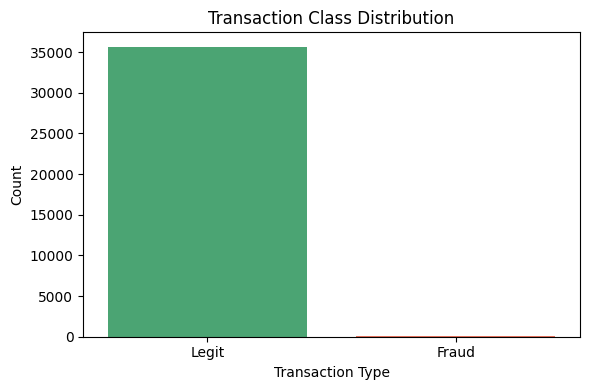

In [7]:
plt.figure(figsize=(6, 4))
sns.countplot(x="Label", data=df, palette=["#3cb371", "#ff6347"])
plt.xticks([0, 1], ["Legit", "Fraud"])
plt.title("Transaction Class Distribution")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

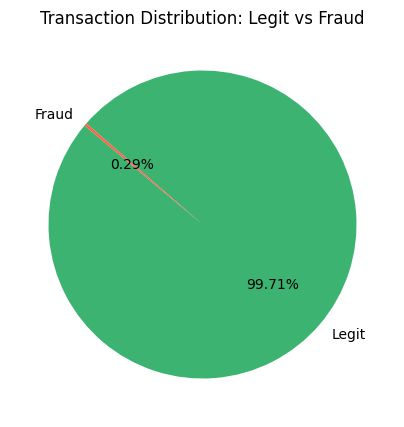

In [8]:
label_counts = df["Label"].value_counts()
labels = ["Legit", "Fraud"]
colors = ["#3cb371", "#ff6347"]

plt.figure(figsize=(5, 5))
plt.pie(label_counts, labels=labels, autopct="%1.2f%%", colors=colors, startangle=140)
plt.title("Transaction Distribution: Legit vs Fraud")
plt.show()

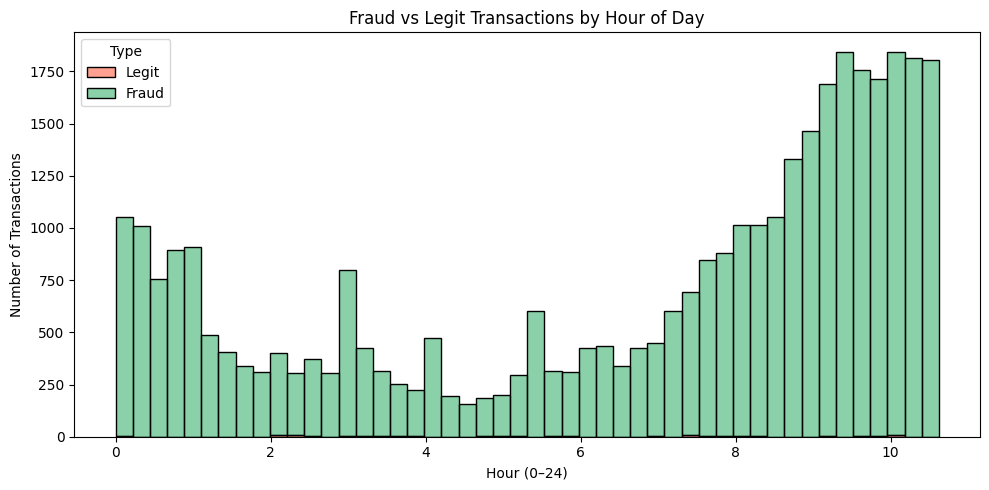

In [9]:
df["Hour"] = (df["Time"] / 3600) % 24

plt.figure(figsize=(10, 5))
sns.histplot(data=df, x="Hour", hue="Label", bins=48, palette=colors, alpha=0.6, multiple="stack")
plt.title("Fraud vs Legit Transactions by Hour of Day")
plt.xlabel("Hour (0–24)")
plt.ylabel("Number of Transactions")
plt.legend(title="Type", labels=["Legit", "Fraud"])
plt.tight_layout()
plt.show()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [17]:
scale_columns = ["Amount"]  # Only scale 'Amount' now
preprocessor = ColumnTransformer([
    ("scaler", StandardScaler(), scale_columns)
], remainder='passthrough')

# Build Pipeline (with SMOTE + XGBoost)
pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", XGBClassifier(
        n_estimators=100,
        scale_pos_weight=15,  # Use imbalance ratio for adjustment
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

In [18]:
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:44:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['Amount'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_c...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [19]:
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

In [20]:
X_test_with_preds = X_test.copy()
X_test_with_preds["Actual"] = y_test.values
X_test_with_preds["Predicted"] = y_pred
X_test_with_preds["Fraud_Probability"] = y_proba

X_test_with_preds.to_csv("fraud_predictions.csv", index=False)

In [21]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))

# Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print("Precision-Recall AUC:", pr_auc)

Confusion Matrix:
 [[10681    11]
 [    5    26]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10692
         1.0       0.70      0.84      0.76        31

    accuracy                           1.00     10723
   macro avg       0.85      0.92      0.88     10723
weighted avg       1.00      1.00      1.00     10723


ROC AUC Score: 0.9598131856196372
Precision-Recall AUC: 0.8028874315463352


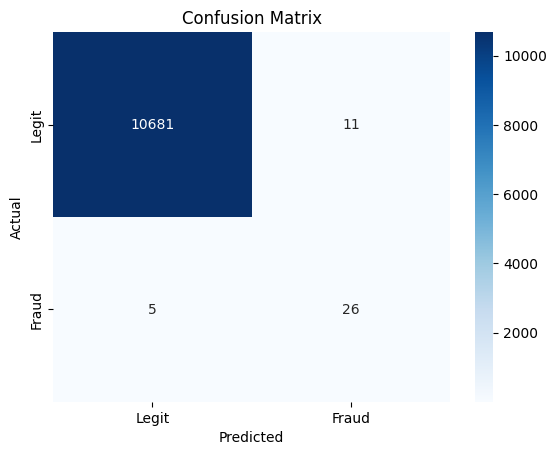

In [22]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Legit", "Fraud"], yticklabels=["Legit", "Fraud"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

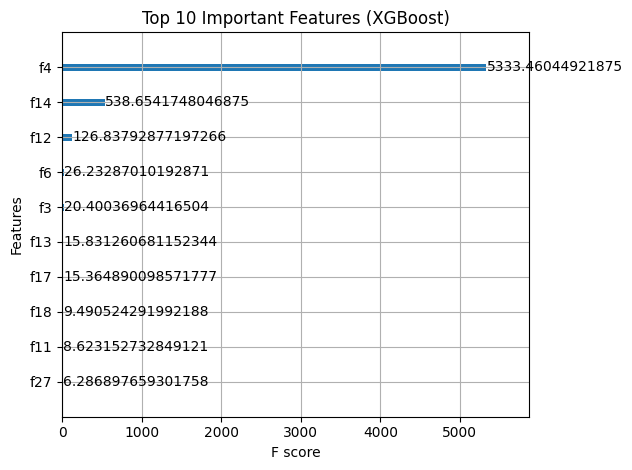

In [23]:
xgb_model = pipeline.named_steps['classifier']
plot_importance(xgb_model, max_num_features=10, importance_type='gain')
plt.title("Top 10 Important Features (XGBoost)")
plt.tight_layout()
plt.show()